## Importar las librerías y funciones requeridas

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from IPython import display
from os import listdir

## Cargar el Modelo YamNet

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1' #selección de un modelo pre-entrenado de YAMNet
yamnet_model = hub.load(yamnet_model_handle)

## Funciones de pre-procesamiento de datos
---

### Convierte los audios al formato requerido

In [3]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename): #el 16k son 16 mil ondas por segundo?
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename) #lee el contenido del archivo y regresa un tensor con el contenido del mismo tal como está
    wav, sample_rate = tf.audio.decode_wav( #decodifica un archivo PCM WAV de 16 bits en un tensor flotante
          file_contents,
          desired_channels=1) #wav es el tensor del contenido del audio (número de ondas)
                              #sample_rate es el número de ondas por segundo
    wav = tf.squeeze(wav, axis=-1) #remueve las dimensiones de tamaño 1
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) #convierte el tensor a tipo entero64
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) #por qué de 16k?
    return wav

### Extrae los Embeddings del modelo YamNet

In [4]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))


### Transforma cada audio del data set|

In [5]:
def load_wav_for_map(filename, label): 
  return load_wav_16k_mono(filename), label #se transforman los datos

### Mapea los nombres de los archivos que conforman el data set

In [6]:
def datos_nec(data_dir, datos): 
  '''función que regresa un vector con la ruta y nombre de los archivos y otro con la etiqueta'''
  filename = []
  etiqueta = []
  ruta_ini = os.path.join(data_dir, datos)
  for clase in clases2:
    ruta = os.path.join(ruta_ini,clase)
    for file in listdir(ruta):
      filename.append(os.path.join(ruta, file))
      etiqueta.append(label2[clase])
  filenames = np.array(filename)
  etiquetas = np.array(etiqueta)
  return filenames, etiquetas


### Utiliza los Embeddings extraidos de YamNet a los inputs

In [7]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

---

## Para nuestros datos

Se definen:

> Ruta de acceso a los datos

> Etiquetas de las clases

In [8]:
os.chdir("D:/ITAM/Deep Learning/Final")

clases2=['Walmart','Chedraui','BodegaAurrera']
my_classes = clases2
datos2=['Train','Test']
label2={'Walmart':0, 'Chedraui':1, 'BodegaAurrera':2}
data_dir = 'data_recortado'

Se obtienen los nombres de los archivos de cada audio que se usarán para entrenamiento y prueba

In [9]:
filenames_train, etiquetas_train = datos_nec(data_dir,'Train')
filenames_test, etiquetas_test = datos_nec(data_dir,'Test')

Acomoda los datos en el formato de tensores requerido

In [10]:
main_ds_train = tf.data.Dataset.from_tensor_slices((filenames_train,  etiquetas_train))
main_ds_test = tf.data.Dataset.from_tensor_slices((filenames_test,  etiquetas_test))

main_ds_train = main_ds_train.map(load_wav_for_map)
main_ds_test = main_ds_test.map(load_wav_for_map)

main_ds_train = main_ds_train.map(extract_embedding).unbatch()
main_ds_test = main_ds_test.map(extract_embedding).unbatch()

Separa los sets de entrenamiento, validación y prueba

In [11]:
train_ds = main_ds_train.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE) #qué está haciendo acá?
val_ds = main_ds_test.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = main_ds_test.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [12]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(1024, activation='selu'),
    tf.keras.layers.Dense(512, activation='selu'),
    tf.keras.layers.Dense(512, activation='selu'),
    tf.keras.layers.Dense(256, activation='selu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,969,155
Trainable params: 1,969,155
Non-trainable params: 0
_________________________________________________________________


In [13]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adamax",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=1000,
                                            restore_best_weights=True)

In [14]:
start = time.time()

history = my_model.fit(train_ds,
                       epochs=400,
                       validation_data=val_ds,
                       callbacks=callback)

end = time.time()
print('Tiempo de Entrenamiento fue: ', end-start, ' segundos.')

Epoch 1/400
338/338 [==============================] - 157s 420ms/step - loss: 0.2919 - accuracy: 0.9136 - val_loss: 2.3826 - val_accuracy: 0.5075
Epoch 2/400
338/338 [==============================] - 8s 22ms/step - loss: 0.3850 - accuracy: 0.9101 - val_loss: 2.3886 - val_accuracy: 0.4700
Epoch 3/400
338/338 [==============================] - 8s 24ms/step - loss: 0.2701 - accuracy: 0.9219 - val_loss: 1.9168 - val_accuracy: 0.5075
Epoch 4/400
338/338 [==============================] - 8s 23ms/step - loss: 0.2608 - accuracy: 0.9256 - val_loss: 1.8787 - val_accuracy: 0.5267
Epoch 5/400
338/338 [==============================] - 8s 23ms/step - loss: 0.2123 - accuracy: 0.9300 - val_loss: 2.1693 - val_accuracy: 0.4908
Epoch 6/400
338/338 [==============================] - 8s 24ms/step - loss: 0.2118 - accuracy: 0.9344 - val_loss: 2.3376 - val_accuracy: 0.5017
Epoch 7/400
338/338 [==============================] - 6s 19ms/step - loss: 0.2307 - accuracy: 0.9280 - val_loss: 2.0541 - val_accura

In [15]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

38/38 [==============================] - 16s 363ms/step - loss: 2.8625 - accuracy: 0.8267
Loss:  2.8625335693359375
Accuracy:  0.8266666531562805


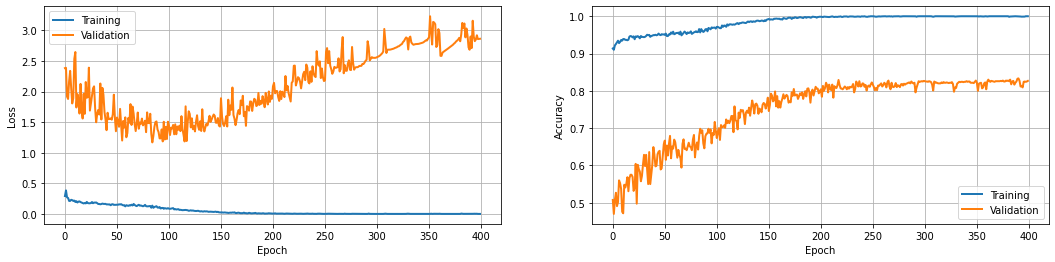

In [16]:
######Graficas de resultados
plt.figure(figsize=(18, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [17]:
# Save model to disk
my_model.save("UR7_1.h5")

In [18]:
# and load it back into memory
#from tensorflow.keras.models import load_model
#my_model = load_model("UR1.h5")